In [4]:
import sys
sys.path.append('/home/ABTLUS/victor.secco/data_processing') 
import os
import numpy as np
import matplotlib.pyplot as plt
import pyFAI
from mypackages.edp_processing import ImageAnalysis, ImageProcessing, peak_calibration
import hyperspy.api as hs
import math
import gc
import copy
import cv2
from PIL import Image

from matplotlib import rcParams, cycler
from matplotlib.ticker import AutoMinorLocator


rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 22
rcParams['axes.linewidth'] = 1.1
rcParams['axes.labelpad'] = 10.0
plot_color_cycle = cycler('color', ['000000', '0000FE', 'FE0000', '008001', 'FD8000', '8c564b', 
                                    'e377c2', '7f7f7f', 'bcbd22', '17becf'])
rcParams['axes.prop_cycle'] = plot_color_cycle
rcParams['axes.xmargin'] = 0
rcParams['axes.ymargin'] = 0
rcParams.update({"figure.figsize" : (6.4,4.8),
                 "figure.subplot.left" : 0.177, "figure.subplot.right" : 0.946,
                 "figure.subplot.bottom" : 0.156, "figure.subplot.top" : 0.965,
                 "axes.autolimit_mode" : "round_numbers",
                 "xtick.major.size"     : 7,
                 "xtick.minor.size"     : 3.5,
                 "xtick.major.width"    : 1.1,
                 "xtick.minor.width"    : 1.1,
                 "xtick.major.pad"      : 3,
                 "xtick.minor.visible" : True,
                 "ytick.major.size"     : 7,
                 "ytick.minor.size"     : 3.5,
                 "ytick.major.width"    : 1.1,
                 "ytick.minor.width"    : 1.1,
                 "ytick.major.pad"      : 5,
                 "ytick.minor.visible" : True,
                 "lines.markersize" : 10,
                 "lines.markerfacecolor" : "none",
                 "lines.markeredgewidth"  : 0.8})





1. Loading Data of Different formats

In [ ]:
#Load Numpy data
directory = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/Fe3O4_classica/Fe3O4_classica_ROI_1/Fe3O4_classica_ROI_1_12.tiff'
files_path = os.path.join(directory, 'Stacked')
names = [x for x in os.listdir(files_path) if x.startswith('Cas70_0.1s_300nm_10eAs')] 
rois = []

for name in names:
    file_path = os.path.join(files_path, name)
    rois.append(np.load(file_path))

np.array(rois).shape

In [17]:
#Load tiff data
directory = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/full_data/Averages/Stacked/Fe3O4_Oley_ROI1_Stacked.tif'
processing = ImageProcessing(directory)
img = processing.load_images(1)

#img = Image.open(directory)
#img = np.array(img)

In [3]:
#Load .ser data
directory = '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/Fe2O3_oleyl/'
names = [x for x in os.listdir(directory) if x.endswith('.ser')] 

file_path = os.path.join(directory, names[3])
data = hs.load(file_path, signal_type='diffraction', lazy=True)
img = np.array(data.mean(axis=0))


2. Encontrando o centro e testes

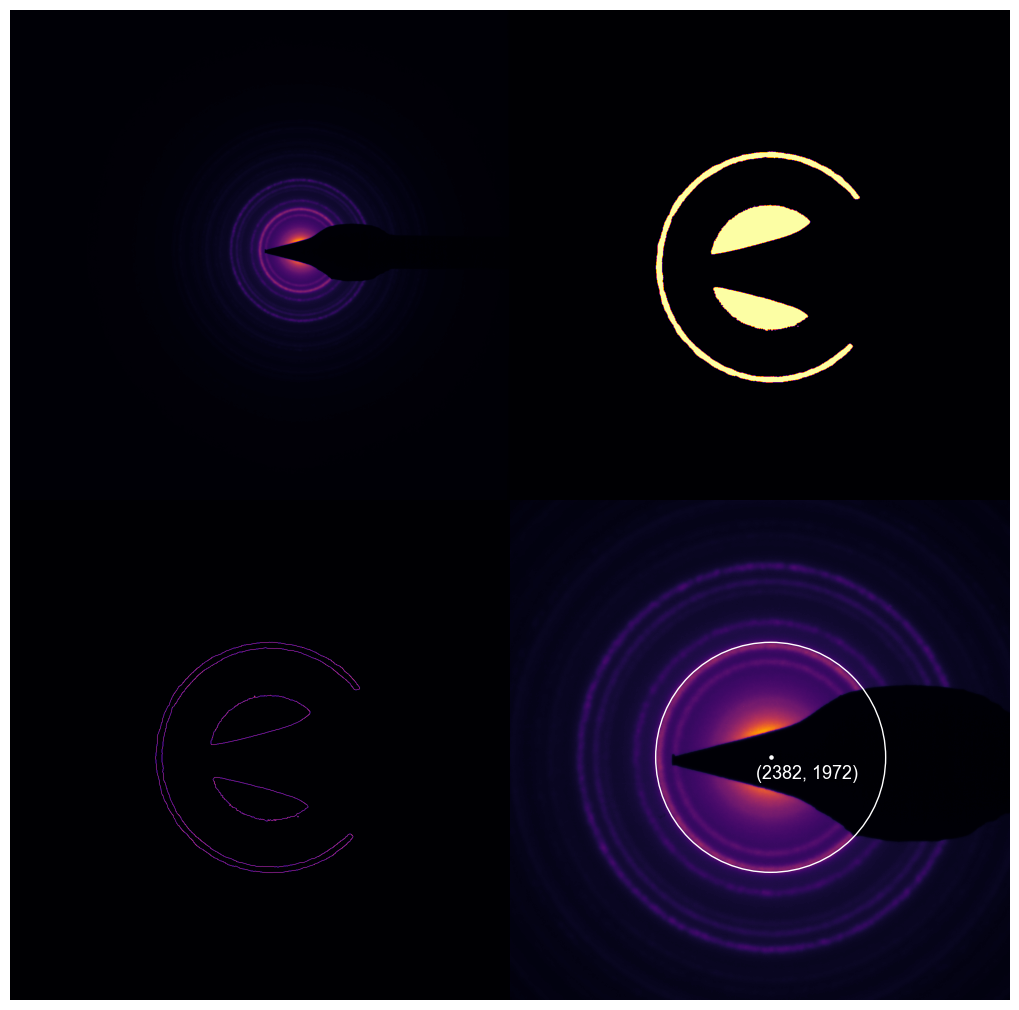

In [18]:
#@title 1.3.1 Encontrar o centro (HOUGH)
import matplotlib.image as mpimg
from matplotlib.patches import Circle
def find_center(image,  r, R, threshold, edges_thresh1 = 255, edges_thresh2 = 10):
        if image is None:
            return "Image not loaded properly. Check the image path."


        blur = cv2.normalize(src=image, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        blur = cv2.GaussianBlur(blur, (3, 3), 30)
        
        final_im = np.where(blur > threshold, 255, 0)
        final_im = final_im.astype(np.uint8)
        
        edges = cv2.Canny(final_im, 0, 255)

        circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=100, param1=edges_thresh1, param2=edges_thresh2, minRadius= r, maxRadius=R)

        if circles is not None:
            circles = np.round(circles[0, :]).astype("int")
            center_x, center_y, r = circles[0]
            return center_x, center_y, r, final_im, edges
        else:
            return final_im, blur, edges

analysis = ImageAnalysis()
center_x, center_y, r, thresh, canny  = find_center(img, 1, 5000, 70, 255, 10)

circle1 = Circle((center_x, center_y), r,  fill = False, color='white')

#center_x, center_y = 2266, 1983
#print('The center found was 'f'{center_x, center_y}')

f, ax = plt.subplots(2,2, figsize = (10,10))
ax[1,1].imshow(img, cmap = 'inferno')
ax[1,1].scatter(center_x, center_y, s=5, color ='white')
ax[1,1].add_patch(circle1)
ax[1,1].axis('off')
ax[1,1].text(center_x+110, center_y+50, f'{center_x, center_y}', color='white', fontsize=13, ha='center', va='center')


zoom_start = 1600
zoom_end = 3100
ax[1,1].set_xlim(zoom_start, zoom_end)
ax[1,1].set_ylim(2700, 1200)  # Note: y-limits are reversed in images


ax[0,0].imshow(img, cmap = 'inferno')
ax[0,0].axis('off')



ax[1,0].imshow(canny, cmap='inferno')
ax[1,0].axis('off')
ax[1,0].set_xlim(zoom_start, zoom_end)
ax[1,0].set_ylim(2700, 1200) 

ax[0,1].imshow(thresh, cmap='inferno')
ax[0,1].axis('off')
ax[0,1].set_xlim(zoom_start, zoom_end)
ax[0,1].set_ylim(2700, 1200) 
#ax[0,1].text(0, 10, 'Identificação de bordas', color='white', fontsize=12, ha='left', va='top')

plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout(pad=0)
#plt.savefig("/home/ABTLUS/victor.secco/data_processing/Imagens/find_center.png", dpi=400)
plt.show()

RuntimeError: Can not put single artist in more than one figure

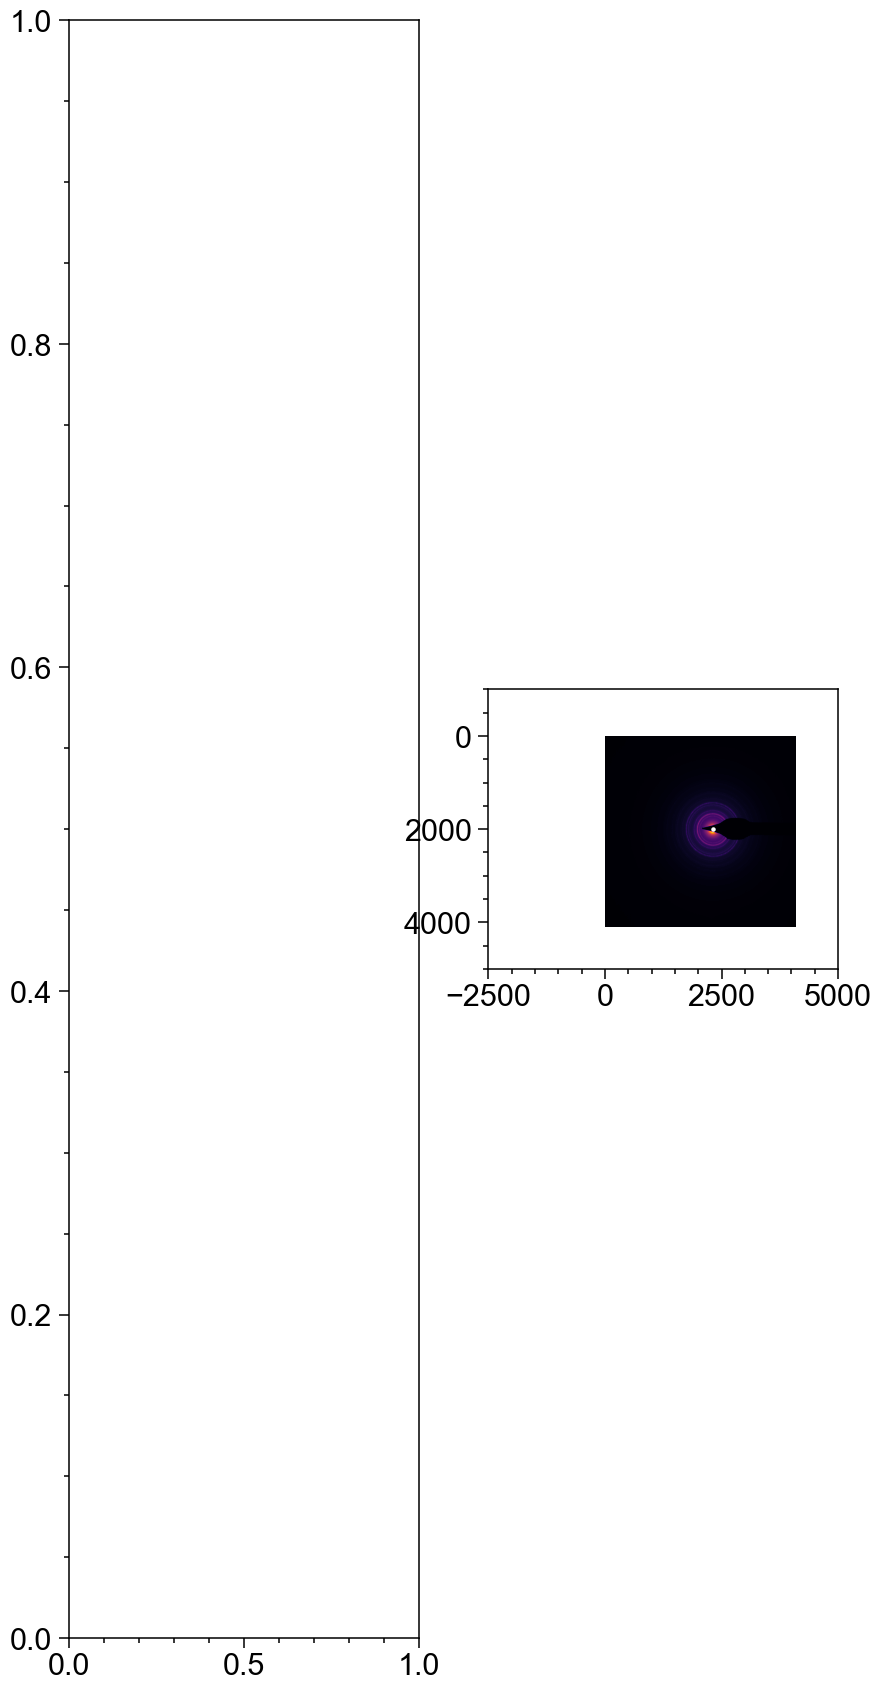

In [7]:
f, ax = plt.subplots(1,2, figsize = (10,20))
ax[1].imshow(img, cmap = 'inferno')
ax[1].scatter(center_x, center_y, s=5, color ='white')
ax[1].add_patch(circle1)
ax[1].axis('off')
ax[1].text(center_x+110, center_y+50, f'{center_x, center_y}', color='white', fontsize=13, ha='center', va='center')


zoom_start = 1600
zoom_end = 3100
ax[1].set_xlim(zoom_start, zoom_end)
ax[1].set_ylim(2700, 1200)  # Note: y-limits are reversed in images


ax[0].imshow(img, cmap = 'inferno')
ax[0].axis('off')


#

  File "/tmp/ipykernel_232959/1608671148.py", line 17, in <module>
    ai = pyFAI.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)


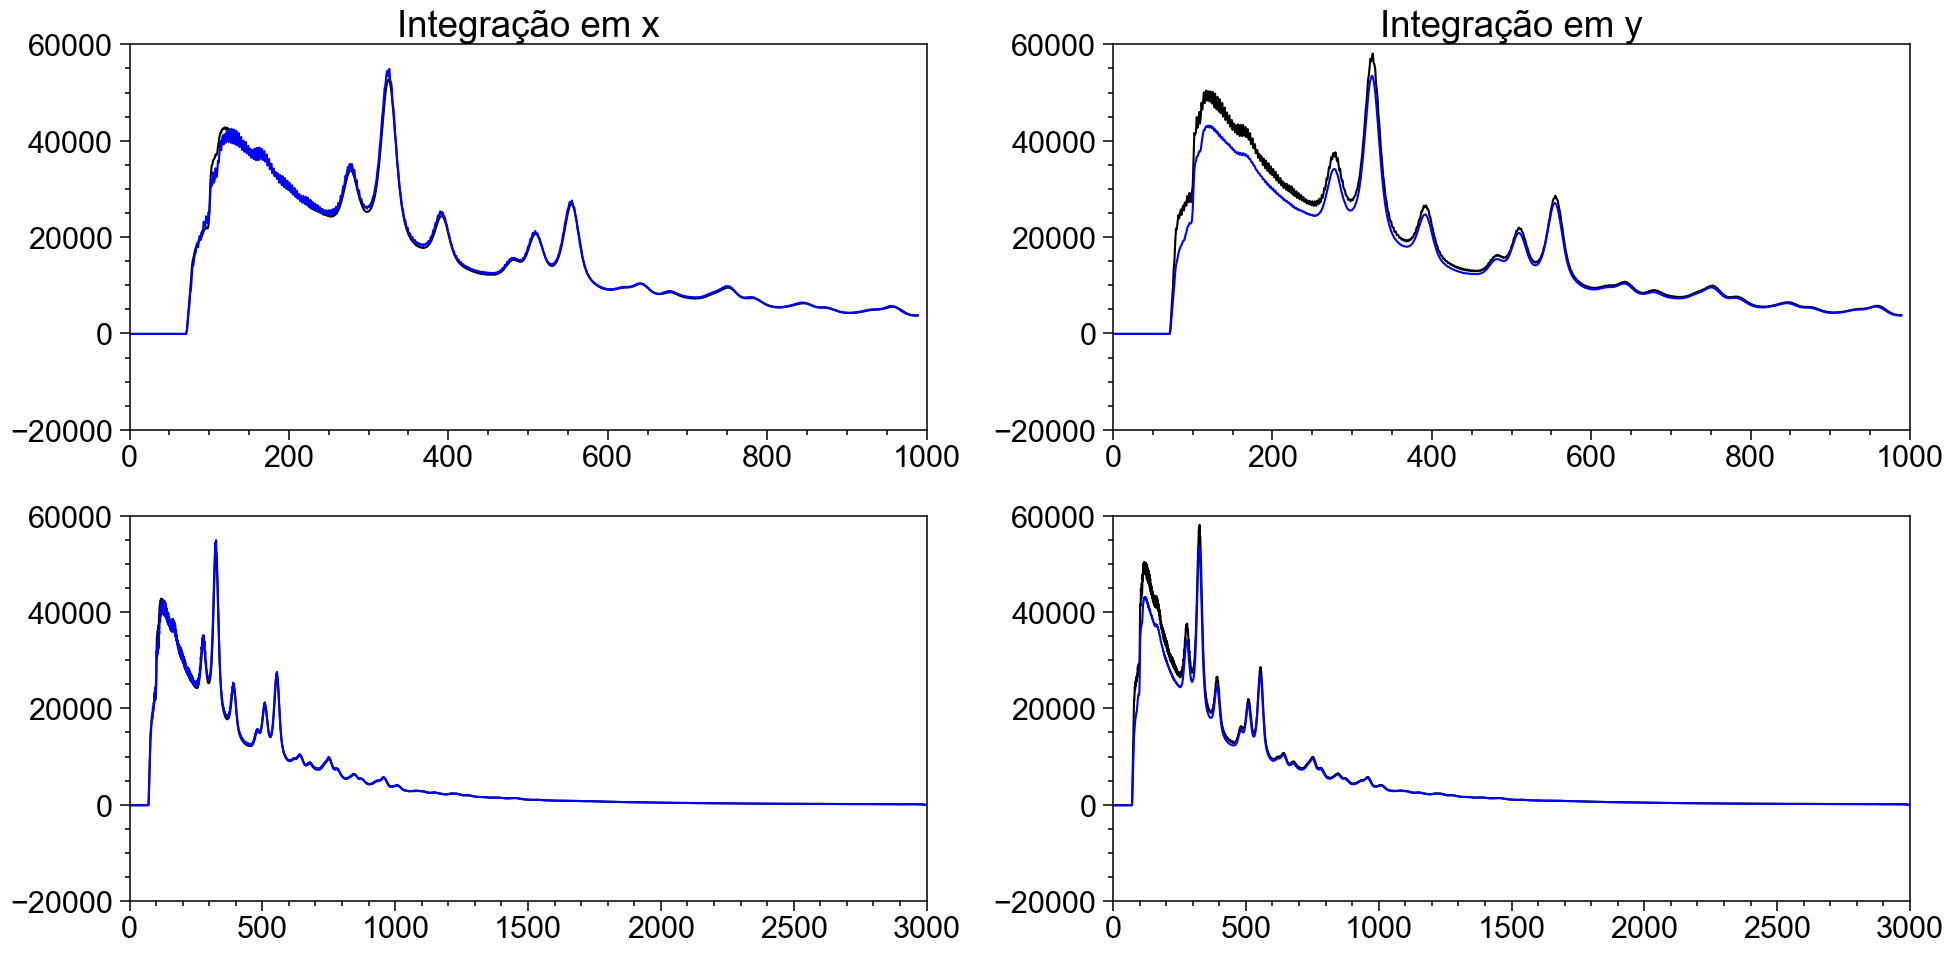

In [19]:
#@title 1.4. Testes com o centro obtido pela transformada de Hough
process = ImageProcessing(directory)

mask = process.load_mask('/home/ABTLUS/victor.secco/data_processing/ED_data/MASKS/mask_titan.tif')
img[mask == 255] = -100

binning = 3000


#center_x, center_y = 2326, 1962

azimuth_ranges_set1 = [(89, 91), (-91, -89)]
azimuth_ranges_set2 = [(-50, -48), (129, 131)]
#center_x, center_y = analysis.optimize_center(masked_stacked, center_x, center_y, azimuth_ranges_set1 + azimuth_ranges_set2, max_iterations = 20)


ai = pyFAI.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)
ai.setFit2D(1024, center_x, center_y)


res1 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(325, 305), method = "ocl_lut_integr")
res2 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(125, 145), method = "ocl_lut_integr")
res3 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(80, 100), method = "ocl_lut_integr")
res4 = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(-80, -100), method = "ocl_lut_integr")

res1, res2 = np.array(res1), np.array(res2)
res3, res4 = np.array(res3), np.array(res4)

fig,ax= plt.subplots(2,2,figsize=(20, 10))

ax[0, 0].set_title('Integração em x')
ax[0, 0].plot(res1[1][0:int(0.33*binning)])
ax[0, 0].plot(res2[1][0:int(0.33*binning)])
#ax[0, 0].text(200, 0.5 * res3[1][100:600].max(), f'Melhor erro: {best_error:.2f} com centro 'f'{best_centro}', fontsize=12, color='red')
#ax[0, 0].text(200, 0.4 * res3[1][100:600].max(), f'EQM: {(erro_x + erro_y):.2f} com centro 'f'{center_x, center_y}', fontsize=12, color='red')

ax[0, 1].set_title('Integração em y')
#ax[0, 1].set_xlim(0, 500)
ax[0, 1].plot(res3[1][0:int(0.33*binning)])
ax[0, 1].plot(res4[1][0:int(0.33*binning)])

ax[1, 0].plot(res1[1])
ax[1, 0].plot(res2[1])

ax[1, 1].plot(res3[1])
ax[1, 1].plot(res4[1])

plt.tight_layout()
plt.show()


3. Integrando e salvando

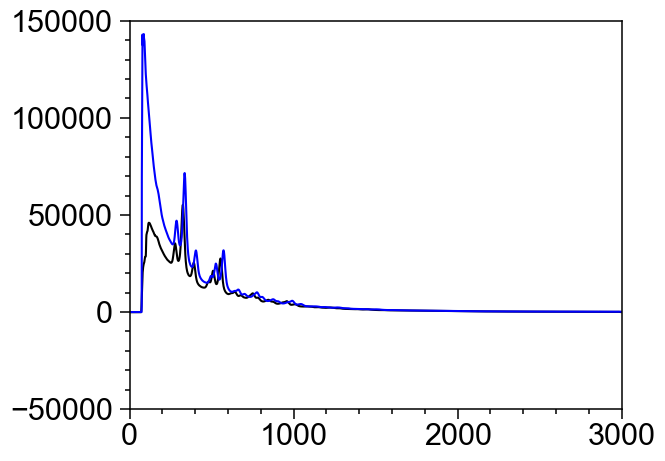

In [20]:
ai = pyFAI.azimuthalIntegrator.AzimuthalIntegrator(dist=0.1, pixel1=1e-4, pixel2=1e-4)
ai.setFit2D(1024, center_x, center_y)

res, intensity = ai.integrate1d(img, binning, unit='2th_deg', azimuth_range=(-180, 180), method = "ocl_lut_integr")
data, polar_image, _ = analysis.azimuth_integration_cv2(img, center = [center_x, center_y], binning= 3000)

plt.plot(intensity)
plt.plot(data)

In [21]:
process.save_iq_only_y(data, '/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/full_data/Averages/IQ/Fe3O4_Oley')

In [11]:
os.path.join(os.path.dirname(directory))

'/home/ABTLUS/victor.secco/data_processing/ED_data/Fe3O4/full_data/Averages/Stacked'

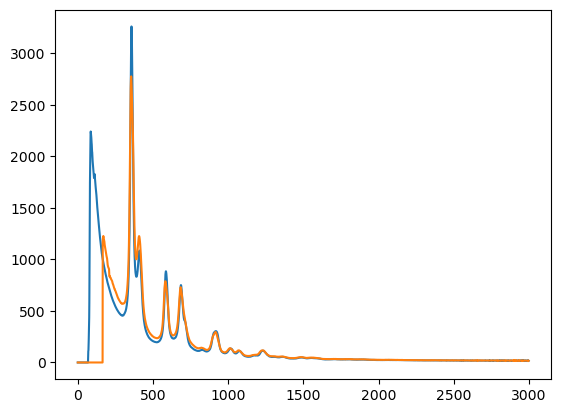

In [41]:
import pandas as pd
import os
import matplotlib.pyplot as plt

df = pd.DataFrame()

files_path = '/home/ABTLUS/victor.secco/data_processing/ED_data/Au/Au_28_may_24'

li = []

files = [file for file in os.listdir(files_path) if file.endswith('.csv')]
files.sort()

for file in files:
    file_path = os.path.join(files_path, file)
    li.append(pd.read_csv(file_path))
    
df = pd.concat(li, axis = 1, ignore_index=True)

for i in range(2):
    plt.plot(df[i].values)

In [ ]:
signal = hs.load(file_path, signal_type='diffraction')


for i, name in enumerate(names[0:]):
    file_path = os.path.join(directory, name)
    # Load the data lazily and change its dtype to float for accurate mean calculation
    signal = hs.load(file_path, signal_type='diffraction', lazy=True)
    signal.change_dtype("int16")
    data = np.array(signal)
    del signal
    stacked = processing.stack_translate(data)
    del data
    output_path = os.path.join(directory, 'Stacked')
    np.save(os.path.join(output_path, f'{name[:-4]}_stacked.npy'), stacked)
    
    gc.collect()